Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensorflow Similarity Supervised Learning Hello World
TensorFlow Similarity is a python library focused on making metric learning with TensorFlow easy. 

It can be used for tasks such as:

- Training and serving models that allow you to find similar items, such as images.

- Create embedding features that can be used to build supervised classifiers.


## Notebook goal

This notebook demonstrates how you can use TensorFlow Similarity to train and query models, enabling the fast retrivial of similar looking items within the MNIST dataset. You are going to learn about the main features offered by the `SimilarityModel()` and will:

 1. `train()` a similarity model on a sub-set of the 10 MNIST classes that will learn how to project digits within a cosine space

 2. `index()` a few examples of each of the classes present in the train dataset (e.g 10 images per classes) to make them searchable

 3. `lookup()` some the test data to check that the train model, despite only having a few examples of the classes unseen during training stored within its index, is still able to retrieve similar looking examples efficiently.

 4. `calibrate()` the model to estimate what is the best distance theshold to separate matching elements from elements belonging to different classes

 5. `evaluate()` how well the model and index performs overall.

 6. `match()` the test dataset to evaluate how well the calibrated model works for classification purpose.

## Things to try 

Along the way you can try the following things to improve the model performance:
- Adding more "seen" classes at training time
- Use a larger embedding by increasing the size of the output
- Add data augmentation pre-processing layers to the model
- Include more examples in the index to give the models more points to choose from.

If you would like to test on more challenging examples, you can replace the MNIST digits dataset with the Fashion MNIST dataset while keeping the notebook almost identical.


In [1]:
import numpy as np
from tabulate import tabulate
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [4]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.layers import MetricEmbedding # row wise L2 norm
from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized similarity loss
from tensorflow_similarity.models import SimilarityModel # TF model with additional features
from tensorflow_similarity.samplers import MultiShotMemorySampler  # sample data 
from tensorflow_similarity.samplers import select_examples  # select n example per class
from tensorflow_similarity.visualization import viz_neigbors_imgs  # neigboors vizualisation
from tensorflow_similarity.visualization import confusion_matrix  # matching performance

In [5]:
tfsim.utils.tf_cap_memory()

In [6]:
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.4.1
TensorFlow Similarity 0.13.9


# Data preparation

We are going to load the MNIST dataset and restrict our training data to **only N of the 10 classes** (6 by default) to showcase how the model is able to find similar examples from classes unseen during training. This is one of the
main reason you would want to use metric learning.


**Important**: Tensorflow similarity expects `y_train` to be an IntTensor containing the class ids for each example. This is different then the standard categorical encoding used for multi-class classification.

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

To learn efficiently each batch must contains at least 2 samples of each class. Additionally it is often useful to have multiple examples of each class so that we can mine for informative triplets using different strategies, e.g., *semi-hard* mining.

To make this easy, tf_similarity offers `Samplers()` that enable you to set the number of classes and the minimum number of examples in each class. Here we are creating a `MultiShotMemorySampler()` which allows you to sample an in-memory dataset and provides multiple examples per class.

TensorFlow Similarity provides various samplers to accomodate different requirements, including `SingleShotMemorySampler()` for single-shot learning, `TFDatasetMultiShotMemorySampler()` that samples directly from a tfds dataset available
in the TensorFlow catalogue, and `TFRecordDatasetSampler()` that allows you to sample from very large datasets
stored on disk as TFRecords shards.

In [8]:
CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
NUM_CLASSES = 6  #@param {type: "slider", min: 1, max: 10}
CLASS_PER_BATCH = NUM_CLASSES
EXAMPLE_PER_CLASS = 6 #@param {type:"integer"}
STEPS_PER_EPOCH = 1000 #@param {type:"integer"}

sampler = MultiShotMemorySampler(x_train, y_train, 
                                 classes_per_batch=CLASS_PER_BATCH, 
                                 examples_per_class_per_batch=EXAMPLE_PER_CLASS,
                                 class_list=CLASSES[:NUM_CLASSES], # Only use the first 6 classes for training.
                                 steps_per_epoch=STEPS_PER_EPOCH)


Batch size is 36 (6 class X 6 example per class pre-augmentation


filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/6 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/36963 [00:00<?, ?it/s]

# Model setup

## Model definition

Metric loss models are normal `tensorflow.keras` models except that their output is a metric embeding. We use `SimilarityModel()` instead of the default `Model()` because this subclass contains an additional proprerty that makes indexing and searching embeddings easy once the training is completed.

In [9]:
def get_model():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.experimental.preprocessing.Rescaling(1/255)(inputs)
    x = layers.Conv2D(32, 7, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 7, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    # smaller embeddings will have faster lookup times
    outputs = MetricEmbedding(64)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          100416    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)     

## Loss definition

Overall what makes Metric losses different from tradional losses is that:
- **They expect different inptus.** Instead of having the prediction and the true values be the same, they expect embeddings as `y_preds` and the id (as int32) of the class as `y_true`. 
- **The require a distance.** You need to specify which `distance` function to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.

In this example we are using the `MultiSimilarityLoss()`. This loss takes a weighted combination of all valid positive and negative pairs, making more efficient use of all the existing information in each batch.

In [10]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
loss = MultiSimilarityLoss(distance=distance)

## Compilation

Tensorflow similarity use an extended `compile()` method that allows you to specify distance_metrics (metrics that are computed over the distance between the embedding). 

By default the `compile()` method tries to infer what type of distance you are using by looking at the fist loss specified. If you use multiples losses and the distance loss is not the first, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [11]:
LR = 0.0001  #@param {type:"float"}
model = get_model()
model.compile(optimizer=Adam(LR), loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


# Training

Similarity models are trained like normal models. 

**NOTE**: don't expect the validation loss to decrease too much here because we only use a subset of the classes within the train data but include all classes in the validation data.

In [12]:
EPOCHS = 10 #@param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))

Epoch 1/10
1000/1000 [==============================] - 9s 5ms/step - loss: 1.7070 - val_loss: 1.4616
Warmup complete
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.9070 - val_loss: 1.3146
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6108 - val_loss: 1.3449
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4162 - val_loss: 1.3513
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3288 - val_loss: 1.3264
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2460 - val_loss: 1.3848
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2600 - val_loss: 1.3875
Epoch 8/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1937 - val_loss: 1.3864
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1338 - val_loss: 1.3609
Epoch 10/10
1000/1000 [==============================] - 5s 5ms/st

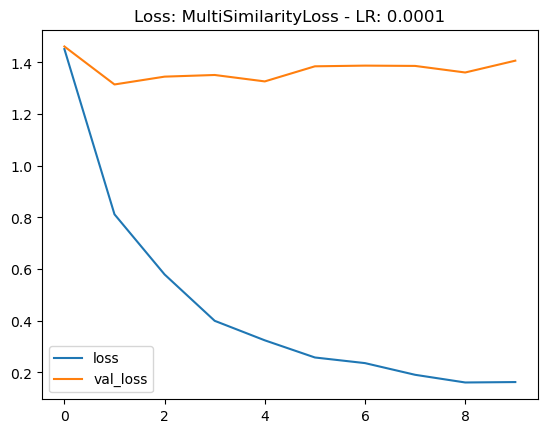

In [13]:
# expect loss: 0.1853 / val_loss: 1.4360
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(f'Loss: {loss.name} - LR: {LR}')
plt.show()

In [14]:
x_index, y_index = select_examples(x_train, y_train, CLASSES, 20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

[Indexing 200 points]
|-Computing embeddings
|-Storing data points in index table
|-Adding embeddings to index.
|-Building index.


# Querying

To "classify" our testing data, we need for each testing example to look for its *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

We query a single random example for each class from the test dataset using  `select_examples()` and then find their nearest neighboors using the `single_lookup()` function.

**NOTE** In the original notebook, classes 8, 5, 0, and 4 were not seen during training but still return reasonable matches in the following plot. 

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

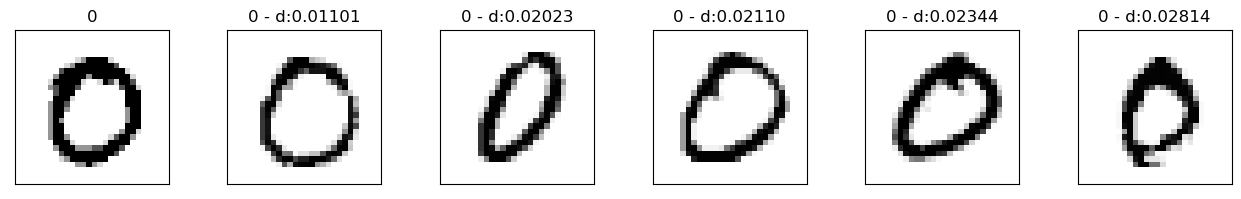

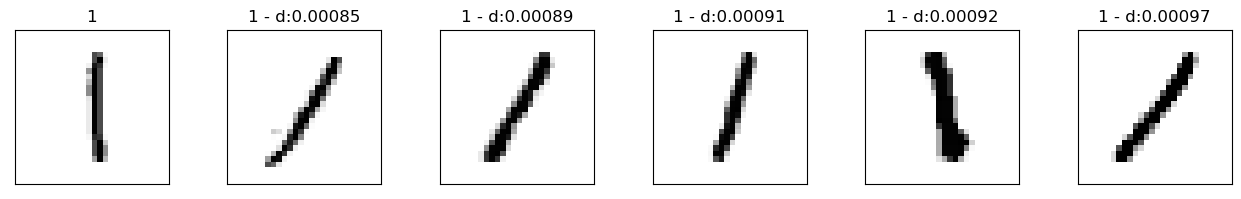

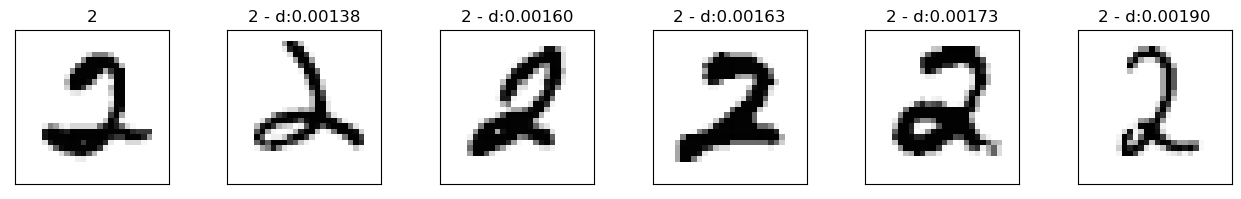

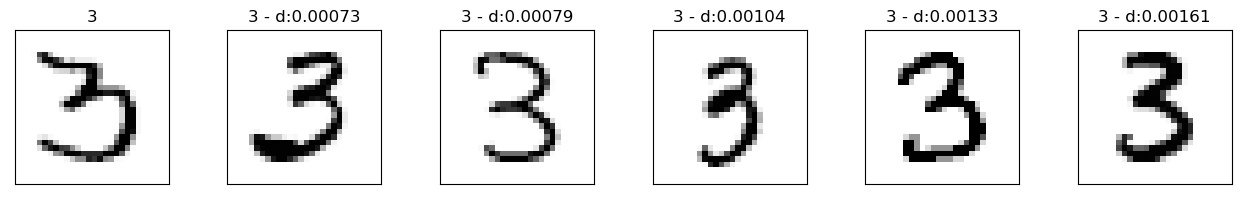

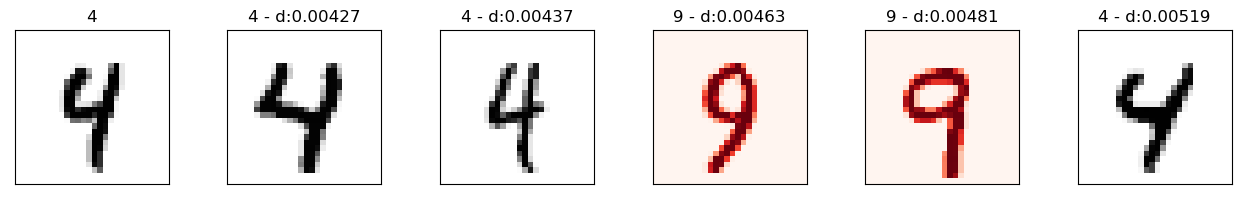

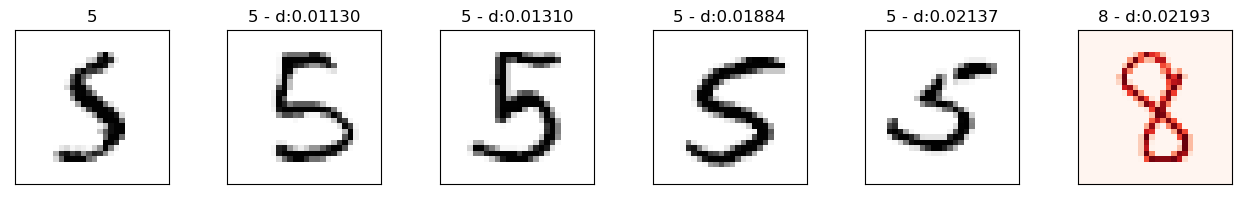

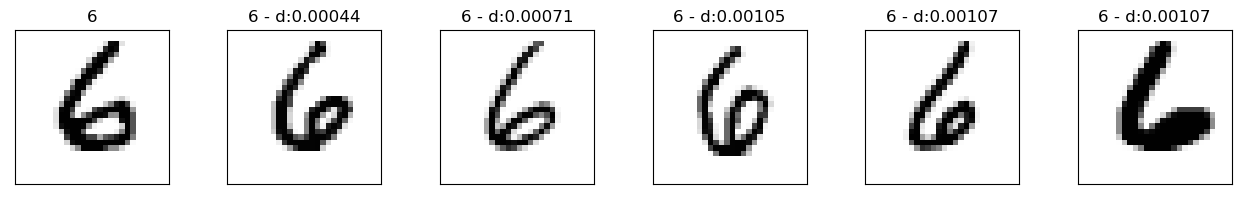

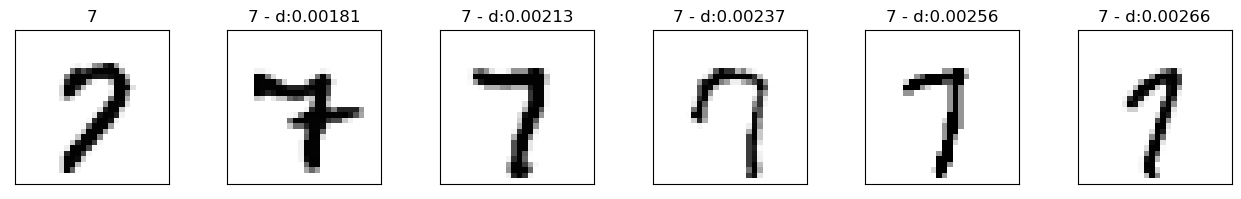

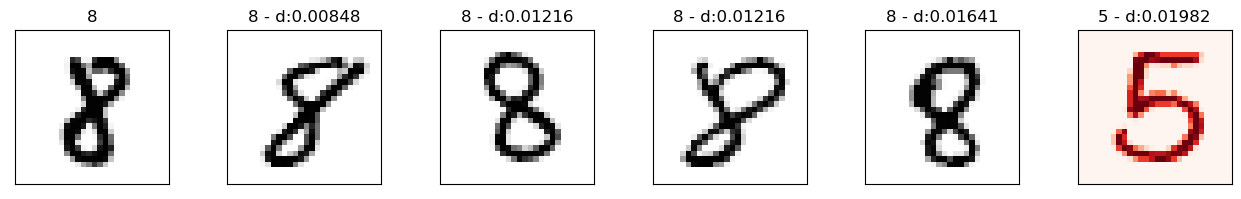

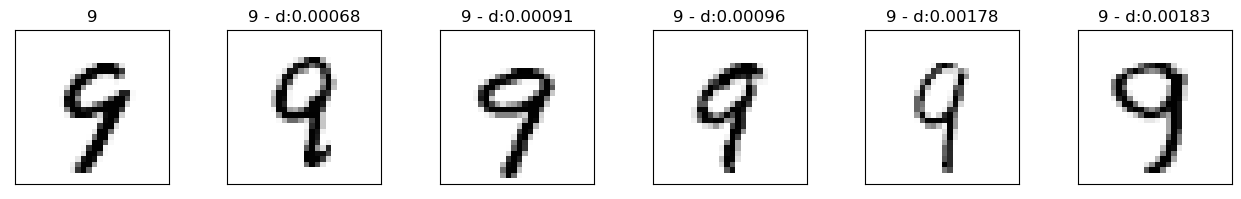

In [56]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
labels = ["0", "1",  "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]

# re-run to test on other examples
num_neighboors = 5

# select
x_display, y_display = select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighboors)

# display
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                      class_mapping=labels, fig_size=(16, 2), cmap='Greys')

## Matching

To be able to tell if an example matches a given class, we first need to `calibrate()` the model to find the optimal cut point. By default, we only compute an optimal cutpoint that maximizes performance; however, you can speficy your own target and change the optimization metrics as illustrated in later examples

In [16]:
num_calibration_samples = 1000
calibration = model.calibrate(x_train[:num_calibration_samples], y_train[:num_calibration_samples], verbose=1)


Performing NN search



Building NN list:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5000 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/5000 [00:00<?, ?it/s]


 name       value    distance    accuracy    recall    f1_score
-------  -------  ----------  ----------  --------  ----------
optimal     0.06   0.0714769        0.03      0.97      0.0582


Let's look at how the performance metrics evolve as the distance between the samples increase. We clearly see the F1 optimial cutpoint where the precision and recall intersect which what the `optimal_cutpoint` represent.

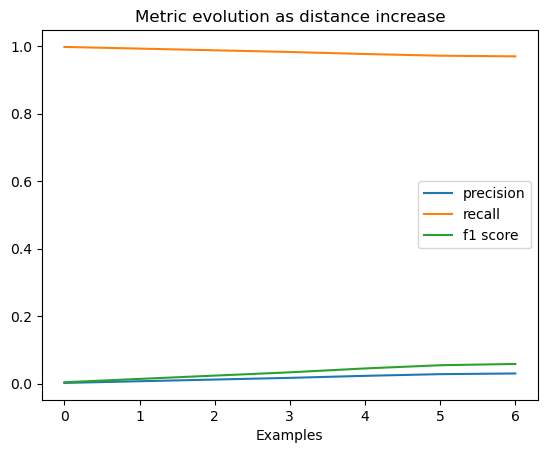

In [17]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['accuracy'], label='precision')
ax.plot(calibration['thresholds']['recall'], label='recall')
ax.plot(calibration['thresholds']['f1_score'], label='f1 score')
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel('Examples')
plt.show()

Ploting the precision/recall curve we can see that for a lot of samples from the unseen classes the model is not doing really well (you see the inflexion past 0.6 recall). This can be improved by indexing more data, using data augmentation, a better model or even changing which classes are trained on. 

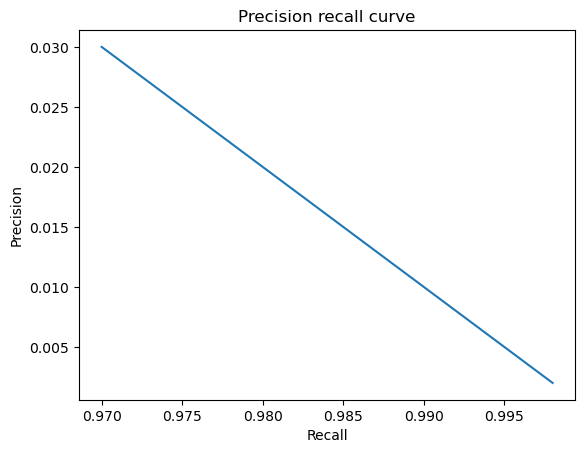

In [18]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['recall'], calibration['thresholds']['accuracy'])
ax.set_title("Precision recall curve")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

# Evaluation
We evaluate our model ability to accurately match new examples using our calibrated threshold by testing how many examples from the test sets are correctly matched. The example which have a distance above the cutoff are excluded and labeled as unknown.

The evaluation below reports the performance of the model fo 

In [19]:
metrics = model.evaluate_matching(x_test, y_test)

|-Computing embeddings


Evaluating cutpoints:   0%|          | 0/1 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/10000 [00:00<?, ?it/s]


 [Summary]

name       f1_score    accuracy    recall    distance
-------  ----------  ----------  --------  ----------
optimal   0.0491299      0.0252    0.9748   0.0714769


## matching

Let's now match a 100 examples to see how you can use the `match()` function in practice. `match()` return you what class the example belong to based of the content of the index and allows to use your model to make prediction on an unbounded, added after training, classes!

Note: `match()` returns -1 by default when the distance between the submitted example and any point in the index is above the distance cutpoint.

In [20]:
num_matches = 10

matches = model.match(x_test[:num_matches], cutpoint='optimal')
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=['Predicted', 'True', 'correct']))

  Predicted    True    correct
-----------  ------  ---------
          7       7          1
          2       2          1
          1       1          1
          0       0          1
          4       4          1
          1       1          1
          9       4          0
          9       9          1
          6       5          0
          4       9          0


## confusion matrix
Let's select a few hundreds samples for each class in the test set to plot the confusion matrix for a few

**NOTE** `tf.math.confusion_matrix` doesn't support negative classes, so we are going to use **class 10 as our unknown class**. Unknown samples are any sample for which the closest neighbor distance is greater than the cutpoint threshold.

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

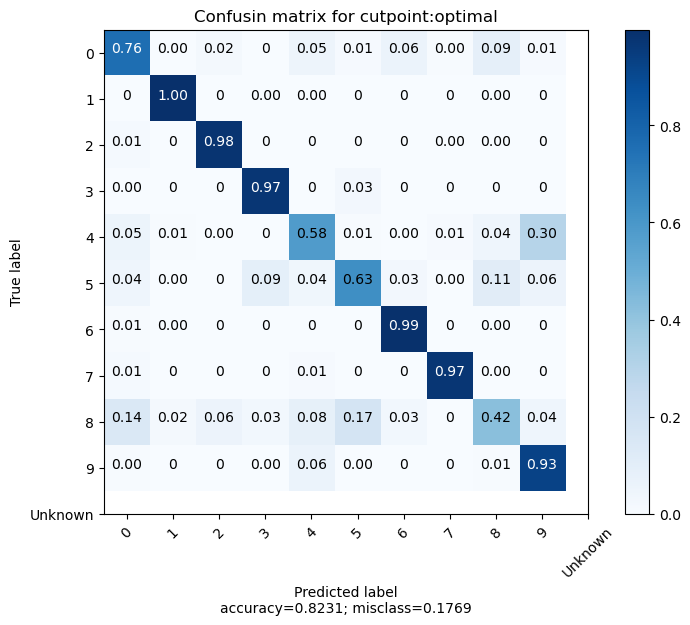

In [21]:
num_example_per_class = 1000
cutpoint = 'optimal'

x_confusion, y_confusion = select_examples(x_test, y_test, CLASSES, num_example_per_class)

matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
confusion_matrix(matches, y_confusion, labels=labels, title='Confusin matrix for cutpoint:%s' % cutpoint)

# Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [22]:
model.index_summary()

[Info]
------------------  --------
distance            cosine
index table         memory
matching algorithm  nmslib
evaluator           memory
index size          200
calibrated          True
calibration_metric  f1_score
embedding_output
------------------  --------



[Performance]
-----------  ---------------
num lookups  21020
min              8.84111e-06
max              8.84111e-06
avg              8.84111e-06
median           8.84111e-06
stddev           0
-----------  ---------------


# Saving and reloading
Saving and reloading the model works as you would expected: 
- `model.save(path)`: save the model and the index on disk (`save_index=False`). By default the index is compressed - can be disabled by setting `compressed=False`
- `model = tf.keras.model.load_model(path)` reload the model. To reload the index you then need to call model.load_index(path)
- `model.save_index(path)` and `model.load_index(path)` allows to save/reload an index indenpendly of saving/loading a model if need to be


## Saving

In [23]:
# save the model and the index
save_path = 'models/hello_world' #@param {type:"string"}
model.save(save_path)

INFO:tensorflow:Assets written to: models/hello_world/assets


INFO:tensorflow:Assets written to: models/hello_world/assets


## Reloading

In [24]:
# reload the model
reloaded_model = load_model(save_path)
# reload the index
reloaded_model.load_index(save_path)

Distance metric automatically set to cosine use the distance arg to override.
Loading index data
loaded 200 records from models/hello_world/index
Loading index matcher
Loading calibration data


In [25]:
#check the index is back
reloaded_model.index_summary()

[Info]
------------------  --------
distance            cosine
index table         memory
matching algorithm  nmslib
evaluator           memory
index size          200
calibrated          True
calibration_metric  f1_score
embedding_output
------------------  --------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


## Query reloaded model
Querying the reloaded model with its reload index works as expected

filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

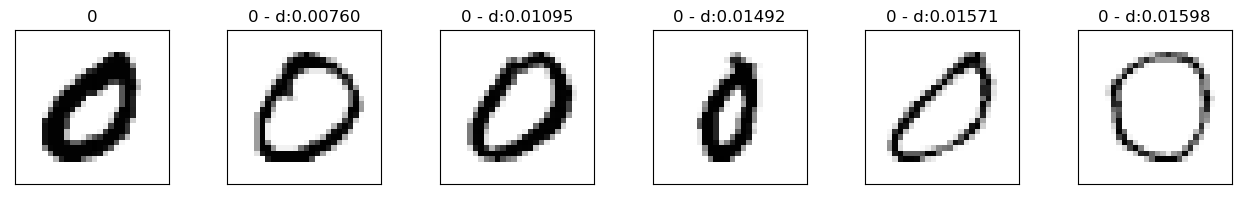

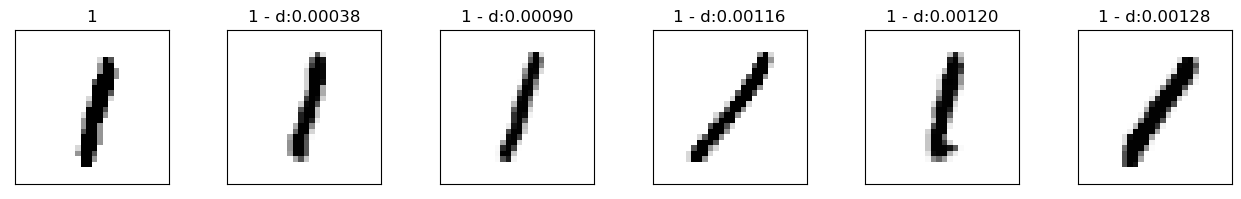

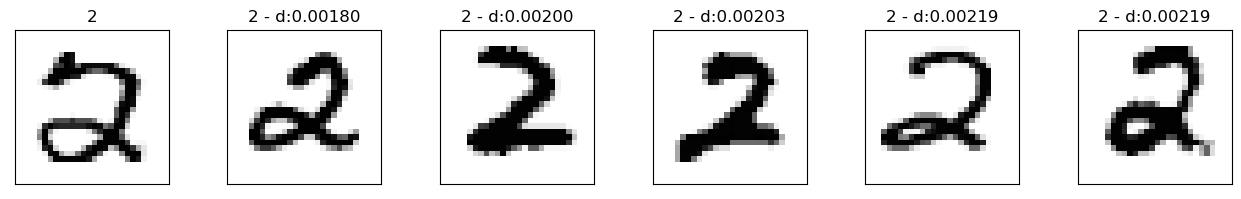

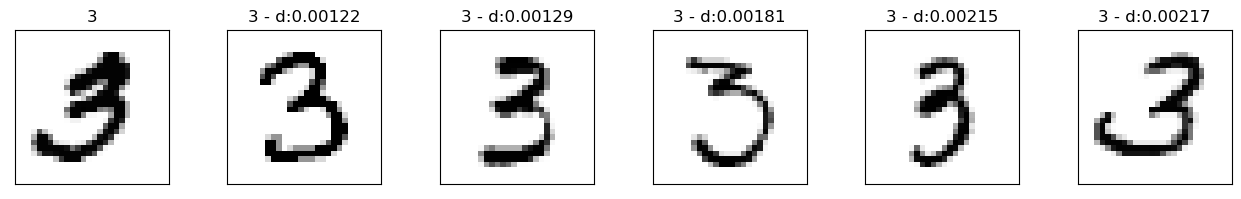

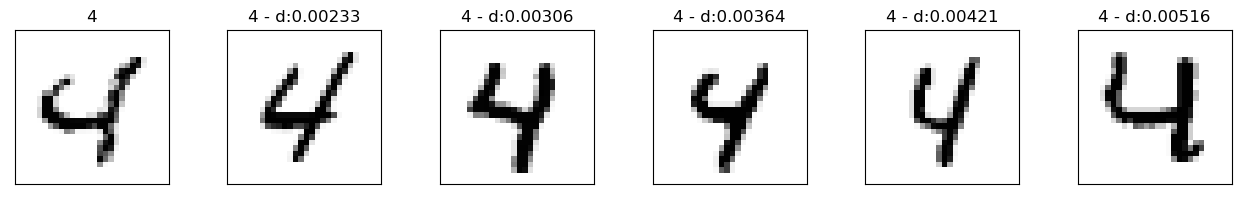

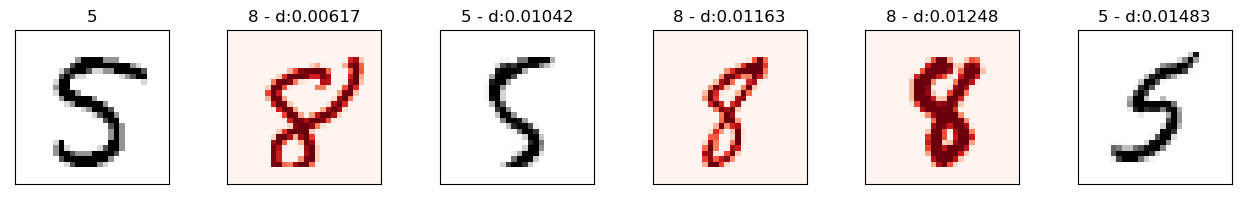

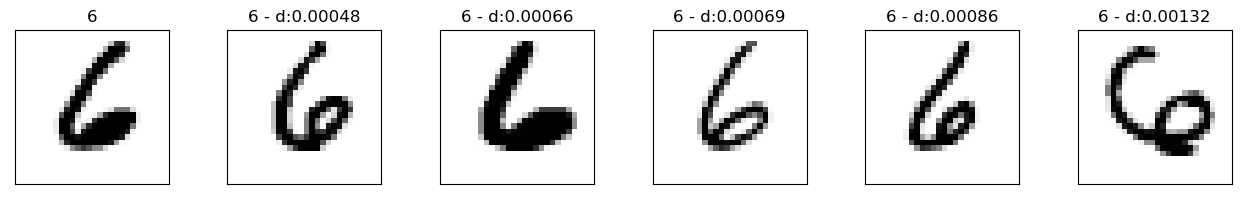

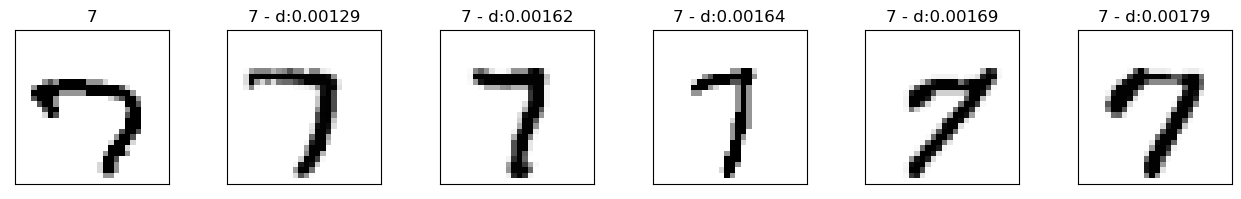

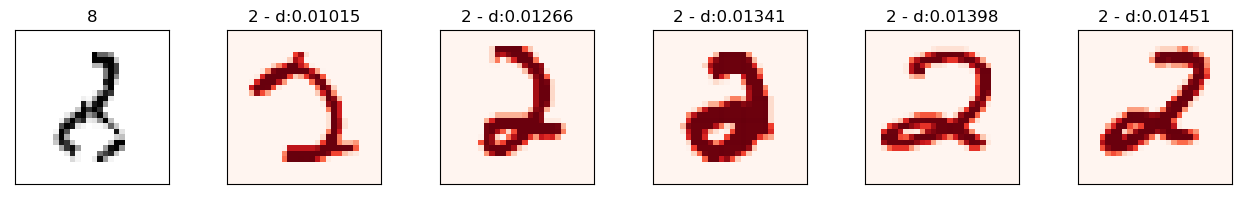

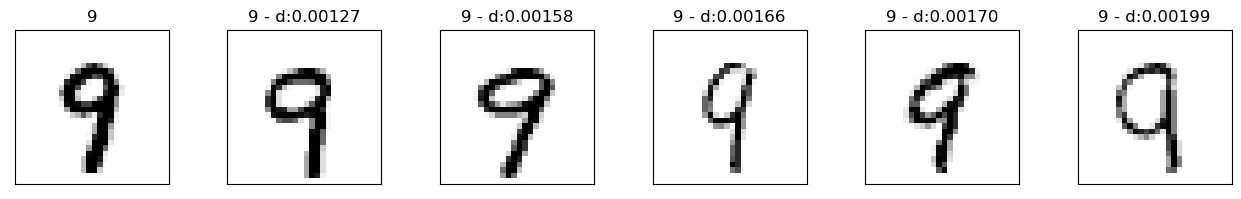

In [71]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
labels = ["0", "1",  "2", "3", "4", "5", "6", "7", "8", "9", "Unknown"]

# re-run to test on other examples
num_neighboors = 5

# select
x_display, y_display = select_examples(x_test, y_test, CLASSES, 1)

# lookup the nearest neighbors
nns = model.lookup(x_display, k=num_neighboors)

# display
for idx in np.argsort(y_display):
    viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], 
                      class_mapping=labels, fig_size=(16, 2), cmap='Greys')